# Задача детекции

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import VOCDetection
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [2]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

dataset = VOCDetection(root='data', year='2007', image_set='train', download=True)

100%|██████████| 460M/460M [00:04<00:00, 96.2MB/s]


In [14]:
def collate_fn(batch):
    images, targets, labels_list = [], [], []
    for img, ann in batch:
        image = np.array(img)
        objects = ann['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        boxes, labels = [], []
        for obj in objects:
            bbox = obj['bndbox']
            boxes.append([
                int(bbox['xmin']), int(bbox['ymin']),
                int(bbox['xmax']), int(bbox['ymax'])
            ])
            labels.append(obj["name"])

        transformed = transform(image=image, bboxes=boxes, class_labels=labels)
        images.append(transformed['image'])
        targets.append(torch.tensor(transformed['bboxes']))
        labels_list.append(labels)

    return torch.stack(images), targets, labels_list


dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [15]:
class ObjectDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.fc(x)


In [16]:
def compute_iou(pred_box, target_box):
    x1 = max(pred_box[0], target_box[0])
    y1 = max(pred_box[1], target_box[1])
    x2 = min(pred_box[2], target_box[2])
    y2 = min(pred_box[3], target_box[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    pred_area = max(0, pred_box[2] - pred_box[0]) * max(0, pred_box[3] - pred_box[1])
    target_area = max(0, target_box[2] - target_box[0]) * max(0, target_box[3] - target_box[1])

    union_area = pred_area + target_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou

def dice_coeff(pred_box, target_box):
    iou = compute_iou(pred_box, target_box)
    return (2 * iou) / (iou + 1)

In [17]:
model = ObjectDetector()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    loader = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

    for images, targets, labels in loader:
        preds = model(images)

        losses = []
        for pred, target in zip(preds, targets):
            gt = target[0]
            loss = criterion(pred, gt)
            losses.append(loss)

        total_loss = torch.stack(losses).mean()
        epoch_loss += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loader.set_postfix(loss=total_loss.item())

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")

model.eval()
ious, dices = [], []

with torch.no_grad():
    for images, targets, _ in dataloader:
        preds = model(images)
        for pred, target in zip(preds, targets):
            gt = target[0]
            iou = compute_iou(pred.tolist(), gt.tolist())
            dice = dice_coeff(pred.tolist(), gt.tolist())
            ious.append(iou)
            dices.append(dice)
        break

print(f"Mean IoU: {np.mean(ious):.4f}, Mean Dice: {np.mean(dices):.4f}")


Epoch 1, Loss: 54.2360


Epoch 2, Loss: 44.5551


Epoch 3, Loss: 43.9973


Epoch 4, Loss: 43.9369


Epoch 5, Loss: 43.8188


Epoch 6, Loss: 44.0219


Epoch 7, Loss: 43.9156


Epoch 8, Loss: 43.8959


Epoch 9, Loss: 43.7214


Epoch 10, Loss: 43.7907
Mean IoU: 0.3380, Mean Dice: 0.4807


In [18]:
def show_image_with_boxes(image_tensor, pred_box, true_box, label_name=None):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.229 + 0.485)
    image = np.clip(image, 0, 1)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    pred_box = [int(x) for x in pred_box]
    true_box = [int(x) for x in true_box]

    ax.add_patch(patches.Rectangle(
        (pred_box[0], pred_box[1]),
        pred_box[2] - pred_box[0],
        pred_box[3] - pred_box[1],
        linewidth=2, edgecolor='r', facecolor='none', label="Predicted"
    ))

    ax.add_patch(patches.Rectangle(
        (true_box[0], true_box[1]),
        true_box[2] - true_box[0],
        true_box[3] - true_box[1],
        linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth"
    ))

    if label_name:
        ax.text(true_box[0], true_box[1] - 10, f"Label: {label_name}",
                color='green', fontsize=12, backgroundcolor='white')

    plt.legend()
    plt.axis('off')
    plt.title("Bounding Boxes with Label")
    plt.show()

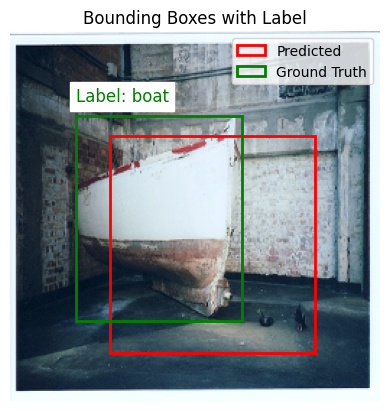

In [19]:
model.eval()
with torch.no_grad():
    for images, bboxes, labels in dataloader:
        preds = model(images)
        show_image_with_boxes(images[0], preds[0], bboxes[0][0], label_name=labels[0][0])
        break